In [6]:
import matplotlib.pyplot as plt
import os, glob, cv2, random
import seaborn as sns
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Preview

In [7]:
path = "./dataset/"

# 학습 데이터 준비 
filenames = os.listdir(path)
X=[]
y=[]
categories=[]
for filename in filenames:
    image = Image.open(path + filename)
    
    image = np.array(image)
    X.append(image)
    category=filename.split("_")[0]
    if category =="close":
        y.append([0])
    else:
        y.append([1])

In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
X.shape, y.shape

((42, 26, 34), (42, 1))

In [10]:
n_total = len(X)
X_result = np.empty((n_total, 26, 34,1))

In [11]:
for i, x in enumerate(X):
    img = x.reshape((26, 34,1))
    
    X_result[i] = img

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_result, y, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

np.save('dataset/x_train.npy', x_train)
np.save('dataset/y_train.npy', y_train)
np.save('dataset/x_val.npy', x_val)
np.save('dataset/y_val.npy', y_val)

(37, 26, 34, 1) (37, 1)
(5, 26, 34, 1) (5, 1)


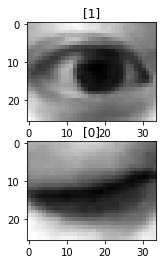

In [13]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[3]))
plt.imshow(x_val[3].reshape((26, 34)), cmap='gray')

C:\Users\wbsl0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

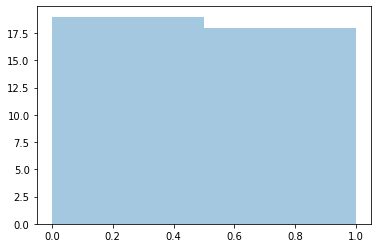

In [14]:
sns.distplot(y_train, kde=False)

<AxesSubplot:>

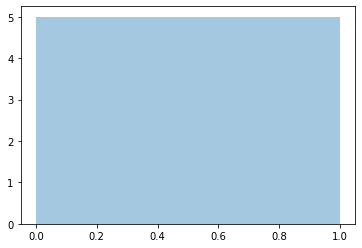

In [15]:
sns.distplot(y_val, kde=False)

In [16]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [17]:
x_train2 = np.load('dataset/x_train.npy').astype(np.float32)
y_train2 = np.load('dataset/y_train.npy').astype(np.float32)
x_val2 = np.load('dataset/x_val.npy').astype(np.float32)
y_val2 = np.load('dataset/y_val.npy').astype(np.float32)

print(x_train2.shape, y_train2.shape)
print(x_val2.shape, y_val2.shape)

(37, 26, 34, 1) (37, 1)
(5, 26, 34, 1) (5, 1)


In [18]:
x_train1 = np.load('make_model/dataset/x_train.npy').astype(np.float32)
y_train1 = np.load('make_model/dataset/y_train.npy').astype(np.float32)
x_val1 = np.load('make_model/dataset/x_val.npy').astype(np.float32)
y_val1 = np.load('make_model/dataset/y_val.npy').astype(np.float32)

print(x_train1.shape, y_train1.shape)
print(x_val1.shape, y_val1.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


In [19]:
x_train = np.concatenate((x_train1,x_train2),axis=0)
y_train = np.concatenate((y_train1,y_train2),axis=0)
x_val = np.concatenate((x_val1,x_val2),axis=0)
y_val = np.concatenate((y_val1,y_val2),axis=0)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2623, 26, 34, 1) (2623, 1)
(293, 26, 34, 1) (293, 1)


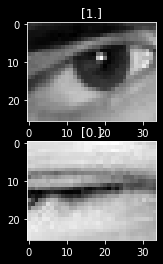

In [20]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [22]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0     

In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('./gaze_tracking/trained_models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50


C:\Users\wbsl0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


82/82 [==============================] - 18s 30ms/step - loss: 0.5667 - acc: 0.6783 - val_loss: 0.2359 - val_acc: 0.8942

Epoch 00001: val_acc improved from -inf to 0.89420, saving model to ./gaze_tracking/trained_models\2021_07_12_15_20_04.h5
Epoch 2/50
82/82 [==============================] - 2s 27ms/step - loss: 0.2863 - acc: 0.8876 - val_loss: 0.1234 - val_acc: 0.9488

Epoch 00002: val_acc improved from 0.89420 to 0.94881, saving model to ./gaze_tracking/trained_models\2021_07_12_15_20_04.h5
Epoch 3/50
82/82 [==============================] - 2s 28ms/step - loss: 0.1868 - acc: 0.9319 - val_loss: 0.0708 - val_acc: 0.9727

Epoch 00003: val_acc improved from 0.94881 to 0.97270, saving model to ./gaze_tracking/trained_models\2021_07_12_15_20_04.h5
Epoch 4/50
82/82 [==============================] - 2s 28ms/step - loss: 0.1459 - acc: 0.9461 - val_loss: 0.0890 - val_acc: 0.9659

Epoch 00004: val_acc did not improve from 0.97270
Epoch 5/50
82/82 [==============================] - 2s 28ms/

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('./gaze_tracking/trained_models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

In [ ]:
ax = sns.distplot(y_pred, kde=False)